# Data Exploration

## import libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## read data

In [2]:
#seed for random gen stuff
#can be changed but must be declared here
#as everything that requires a seed will use this

seed = 10

#labeled data

star3642 = pd.read_csv("Star3642_balanced.csv")
star39552 = pd.read_csv("Star39552_balanced.csv")

## relabel spectral classes in labeled data

There's too many subcategories for each spectral type so they will be classified into larger bins (might undo later)

In [3]:
#categories

cat = ['A', 'B', 'C', 'F', 'G', 'K', 'M', 'N', 'O', 'W']
encoder = LabelEncoder()
encoder.fit(cat)


#change categories
for i in cat:
    #labeled
    star3642['SpType'] = star3642['SpType'].apply(str).str.replace("^"+i,i)
    star39552['SpType'] = star39552['SpType'].apply(str).str.replace("^"+i,i)

#Labeling categories

star3642['SpType'] = encoder.transform(star3642['SpType'])
star39552['SpType'] = encoder.transform(star39552['SpType'])

*From here onwards is the data exploration*

## Using preprocessing library to look at labeled data

This is basically observing the data using the methods given in the ipynb files from class (not all of them just some). Observing star39552 cause it has more values.

Will be grouped into groups of 2 or 3 because final classifying results are either Dwarf (0) or Giant (1). The 3rd group will be ones that are not immediately decidable and will have to go through extra processing in the final model.

### Visualizing Correlation Between Numerical Variables

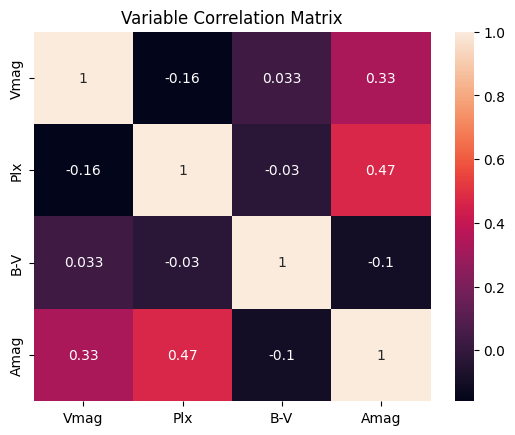

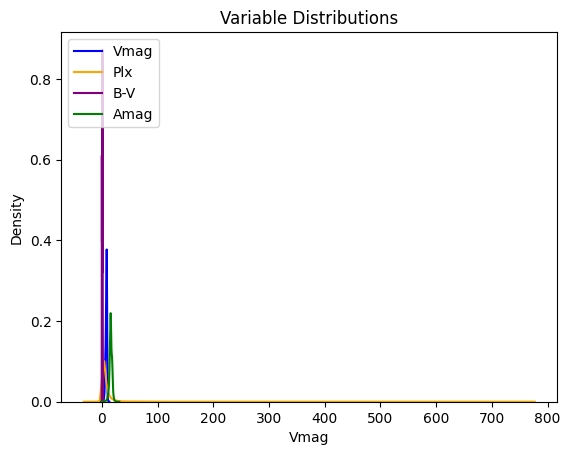

k best for Vmag
[-5.92494616e+15  2.20490136e+01  1.64276950e+00  7.90740424e+00]
k best for Plx
[ 2.60730355         inf  1.07977844 32.66263378]
k best for B-V
[3.28375893e+00 2.94831679e+00 1.61451531e+16 1.05773212e+01]
k best for Amag
[10.87456276 22.04633901  0.92971331         inf]


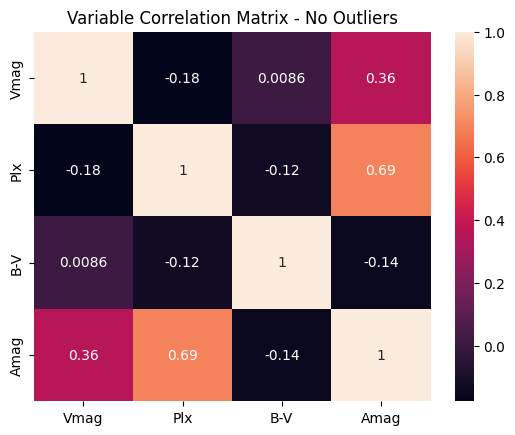

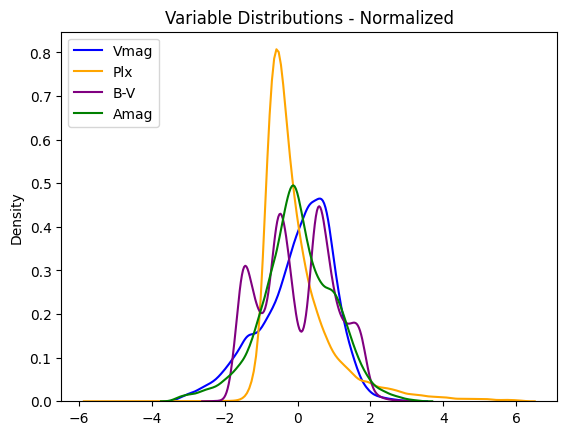

Outliers and distribution


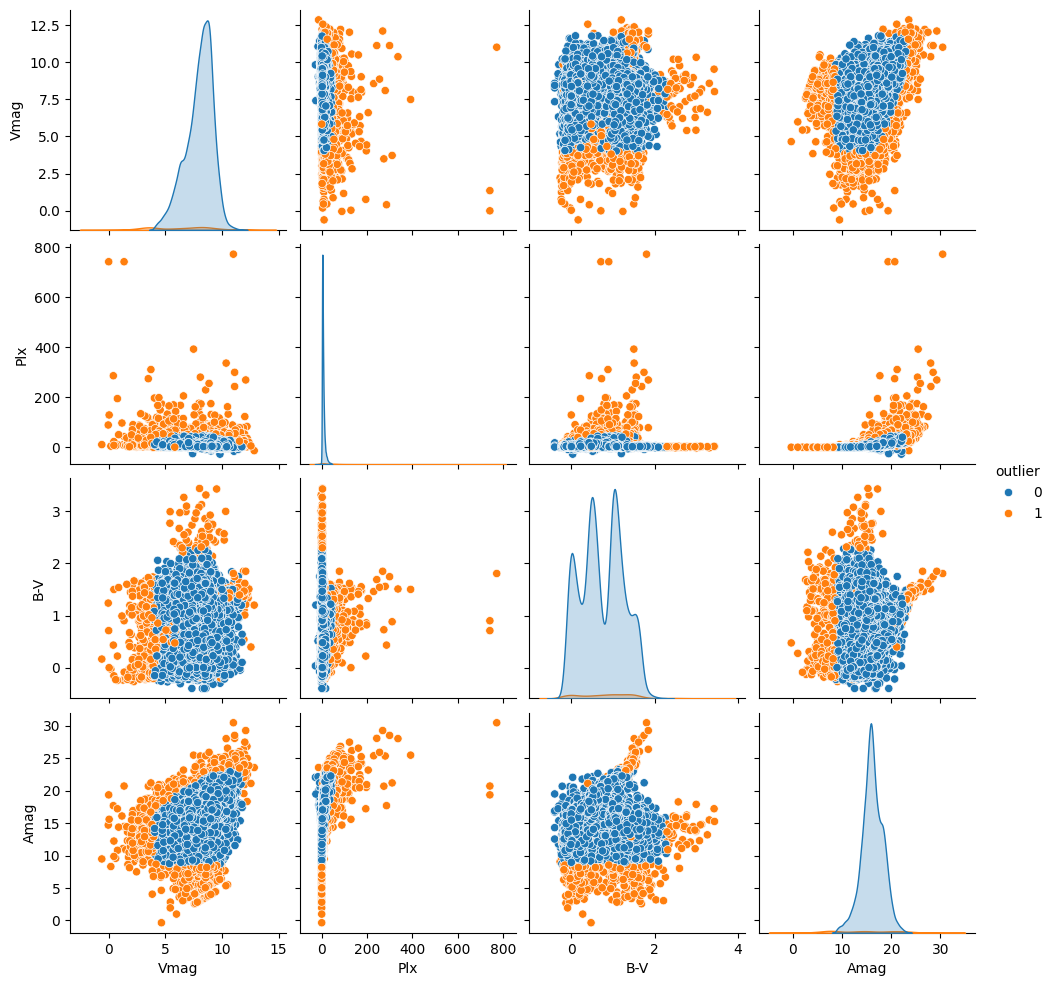

In [4]:
#not including Plx Error because its not an actual
#value rather a measure of another value

#Correlation Matrix
numCol = star39552[['Vmag', 'Plx', 'B-V','Amag']]
corMat = numCol.corr()
sns.heatmap(corMat, annot=True)
plt.title("Variable Correlation Matrix")
plt.show()


#Data distribution
sns.kdeplot(x=numCol['Vmag'], color='blue', label="Vmag")
sns.kdeplot(x=numCol['Plx'], color='orange', label="Plx")
sns.kdeplot(x=numCol['B-V'], color='purple', label="B-V")
sns.kdeplot(x=numCol['Amag'], color='green', label="Amag")
plt.legend(loc="upper left")
plt.title("Variable Distributions")
plt.show()

#K best
X = numCol.values
y = numCol['Vmag']
model = SelectKBest(k=2)
selector = model.fit(X, y)
print("k best for Vmag")
print(selector.scores_)

y = numCol['Plx']
selector = model.fit(X, y)
print("k best for Plx")
print(selector.scores_)

y = numCol['B-V']
selector = model.fit(X, y)
print("k best for B-V")
print(selector.scores_)

y = numCol['Amag']
selector = model.fit(X, y)
print("k best for Amag")
print(selector.scores_)

#this isnt even necessary but i like how it looks
#sns.pairplot(data=numCol, kind='kde')

#data distribution, normalized, remove outliers

numCols = numCol[(np.abs(zscore(numCol)) < 3).all(axis=1)]
scaler = StandardScaler()
numCol_s = scaler.fit_transform(numCols.values)


corMat = numCols.corr()
sns.heatmap(corMat, annot=True)
plt.title("Variable Correlation Matrix - No Outliers")
plt.show()

sns.kdeplot(x=numCol_s[:,0], color='blue', label="Vmag")
sns.kdeplot(x=numCol_s[:,1], color='orange', label="Plx")
sns.kdeplot(x=numCol_s[:,2], color='purple', label="B-V")
sns.kdeplot(x=numCol_s[:,3], color='green', label="Amag")
plt.legend(loc="upper left")
plt.title("Variable Distributions - Normalized")
plt.show()

#label outliers
outliers = np.sum((np.abs(zscore(numCol)) > 3).astype(int),axis=1)
outliers = pd.Series(outliers)


numCol['outlier'] = outliers.apply(lambda x : 1 if x > 0 else 0)

#plot outliers
print("Outliers and distribution")
sns.pairplot(numCol, hue="outlier")
plt.show()

numCols = star39552[['Vmag', 'Plx', 'B-V','Amag', 'TargetClass']]
numCols = numCols[(np.abs(zscore(numCol)) < 3).all(axis=1)]

### Visualizing Correlation between Numerical Variables and Dwarf/Giant Classification

In [5]:
#prepare data to run later

#regular data
BV = star39552['B-V']
Plx = star39552['Plx']
Vmag = star39552['Vmag']
Amag = star39552['Amag']
comp = star39552

#no outliers data, comment out to see
#raw data
BV = numCols['B-V']
Plx = numCols['Plx']
Vmag = numCols['Vmag']
Amag = numCols['Amag']
comp = numCols

#### Visual Magnitude & Actual Magnitude

*Overview*

In [6]:
#prepare data to run later
data = pd.DataFrame([Vmag, Amag])

df = pd.DataFrame.transpose(data)

BINS
[39583 39521]
EDGES
[array([10.      , 16.251278, 22.502556])
 array([ 8.26     , 12.0262625, 15.792525 ])
 array([ 8.27    , 13.533776, 18.797552]) ...
 array([ 9.21    , 13.184874, 17.159748])
 array([ 9.01    , 12.330949, 15.651898])
 array([ 9.12     , 13.0751585, 17.030317 ])] 3


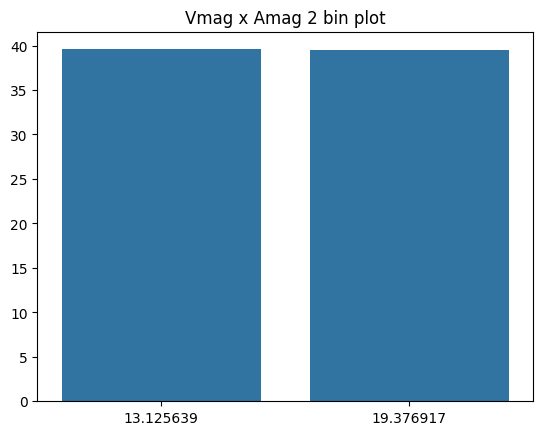

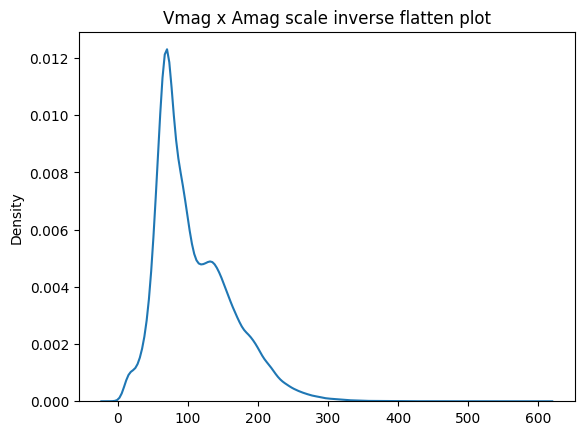

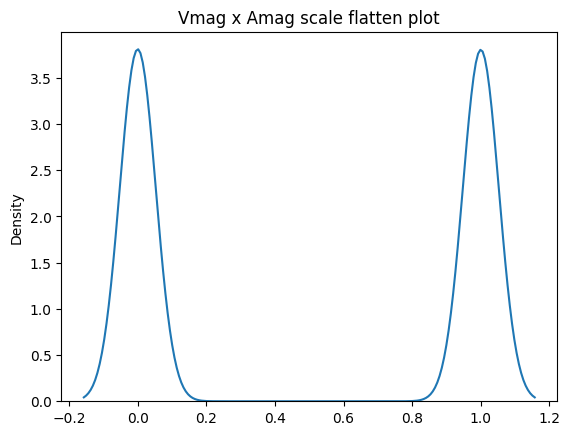

In [7]:
#Kbins

#3 bins arent needed after testing this
kb2 = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
#kb3 = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
Vmagbin2 = kb2.fit_transform(data)
#Vmagbin3 = kb3.fit_transform(data)

bins2 = np.bincount(np.ndarray.flatten(Vmagbin2).astype(int))
#bins3 = np.bincount(np.ndarray.flatten(Vmagbin3).astype(int))

print("BINS")
print(bins2)
#print(bins3)

edges2 = kb2.bin_edges_
#edges3 = kb3.bin_edges_

print("EDGES")
print(edges2, len(edges2[0]))
#print(edges3, len(edges3[0]))

coods_2 = [(edges2[0][i] + edges2[0][i+1])/2 for i in range(len(edges2[0]) - 1)]
#coods_3 = [(edges3[0][i] + edges3[0][i+1])/2 for i in range(len(edges3[0]) - 1)]

#bin plots
sns.barplot(x=coods_2, y=bins2/1000)
plt.title("Vmag x Amag 2 bin plot")
plt.show()

#sns.barplot(x=coods_3, y=bins3/1000)
#plt.title("Vmag 3 bin plot")
#plt.show()

#minmax scaler

scaler = MinMaxScaler()
Vmag_sca = scaler.fit_transform(data)
Vmag_inv = scaler.inverse_transform(data)


sns.kdeplot(x=Vmag_inv.flatten())
plt.title("Vmag x Amag scale inverse flatten plot")
plt.show()

sns.kdeplot(x=Vmag_sca.flatten())
plt.title("Vmag x Amag scale flatten plot")
plt.show()


With the minmax scales it's easy to see there's a clear divide between the data

*Observing Clusters*

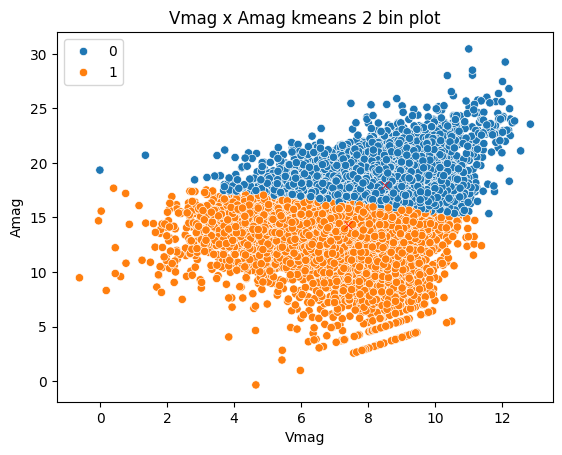

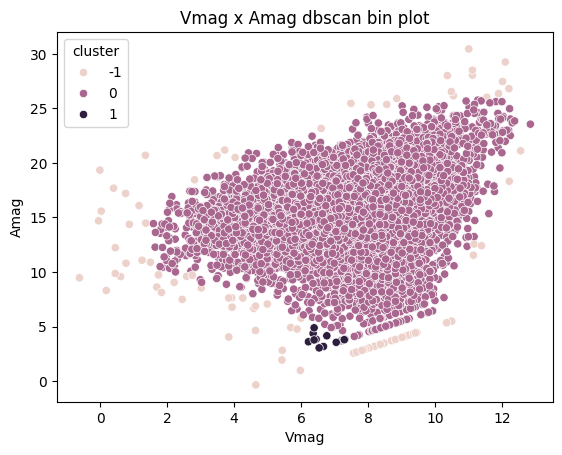

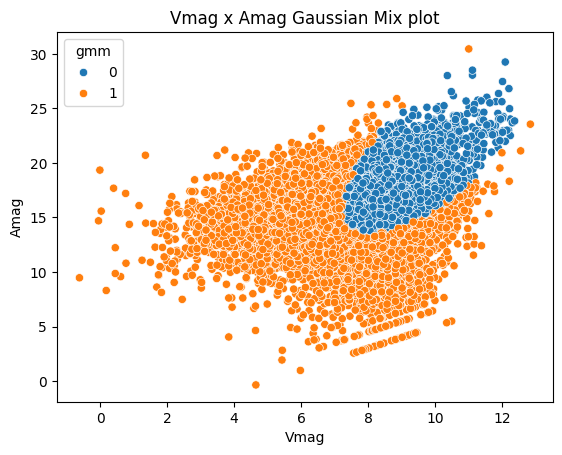

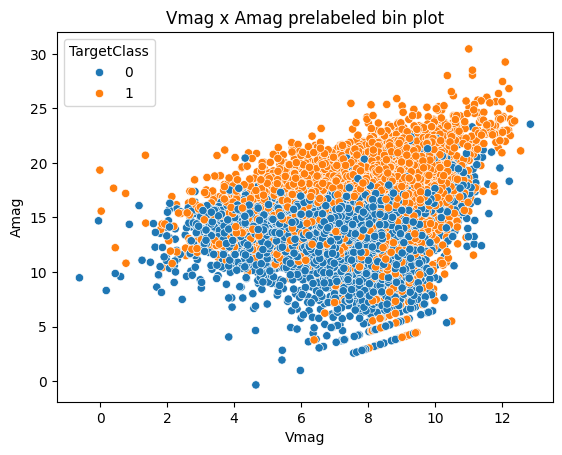

Accuracy Results:
KMeans: 0.7312904530744336
Gaussian Mix: 0.4140625


In [8]:
#plot all together later
#figure, axis = plt.subplots(2, 2) 

#KMEANS observing

#init and max are pretty high since the dataset is large        
km2 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
#km3 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
   
km2.fit(df)
#km3.fit(df)

#use index as x value
#x = Vmag.index.values  

clusters = pd.DataFrame(df)
clusters['label'] = km2.labels_

#scatterplot of kmeans data
sns.scatterplot(data=clusters, x='Vmag', y='Amag', hue='label')
sns.scatterplot(x=km2.cluster_centers_[:, 0], y=km2.cluster_centers_[:,1], color='red', marker='x')
plt.title("Vmag x Amag kmeans 2 bin plot")
plt.show()

km = sum(clusters['label'] != comp['TargetClass']) 

#DBSCAN
        
#maybe try with minmax scaler as well?

scaler2 = StandardScaler()
VmagStand = scaler2.fit_transform(df)
dbscan = DBSCAN(eps=0.5, min_samples=20)
clus = dbscan.fit_predict(VmagStand)
n_clusters = len(set(dbscan.labels_)) 

#ideally 3 at most ^

#visualize dbscan 
clusters = pd.DataFrame(df)
clusters['cluster'] = clus

sns.scatterplot(data=clusters, x='Vmag', y='Amag', hue='cluster')
plt.title("Vmag x Amag dbscan bin plot")
plt.show()

#Gaussian mix

gmm = GaussianMixture(n_components=2, max_iter=200)
gmm_cluster_labels = gmm.fit_predict(df)
clusters = pd.DataFrame(df)
clusters['gmm'] = gmm_cluster_labels
sns.scatterplot(data=clusters, x='Vmag', y='Amag', hue='gmm')
plt.title("Vmag x Amag Gaussian Mix plot")
plt.show()

gm = sum(clusters['gmm'] == comp['TargetClass']) 


#scatterplot of prelabeled data
sns.scatterplot(data=comp, x='Vmag', y='Amag', hue='TargetClass')
plt.title("Vmag x Amag prelabeled bin plot")
plt.show()

#compare results

print("Accuracy Results:")
print("KMeans:", km/len(comp['TargetClass']))
print("Gaussian Mix:", gm/len(comp['TargetClass']))

#### Visual Magnitude & Distance from Earth

*Overview*

In [9]:
#prepare data to run later
data = pd.DataFrame([Plx, Vmag])

df = pd.DataFrame.transpose(data)

BINS
[39569 39535]
EDGES
[array([10.  , 20.83, 31.66]) array([3.21 , 5.735, 8.26 ])
 array([ 8.27, 10.51, 12.75]) ... array([3.89, 6.55, 9.21])
 array([2.13, 5.57, 9.01]) array([3.82, 6.47, 9.12])] 3


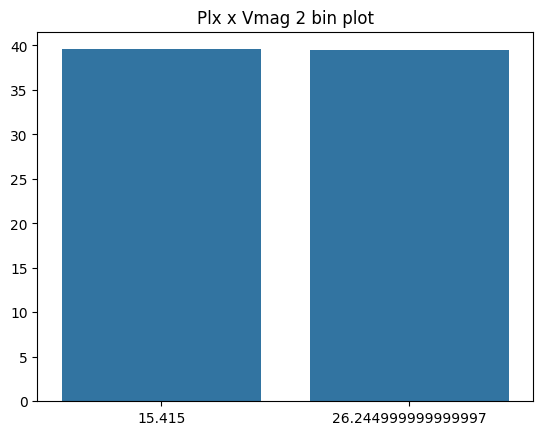

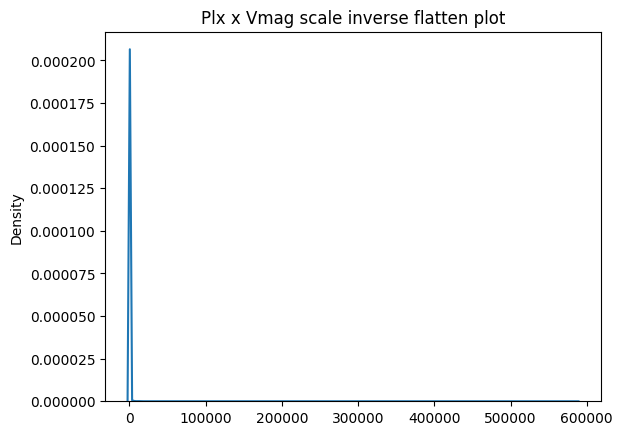

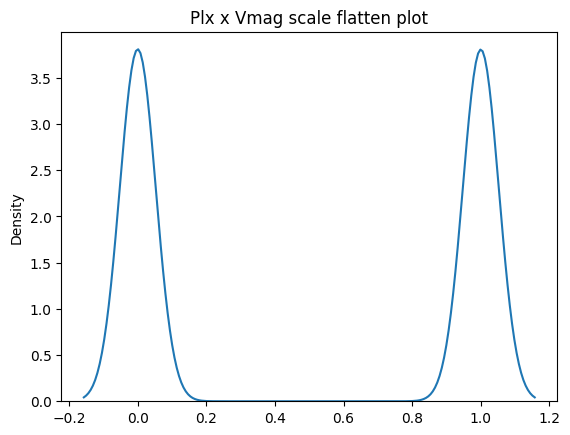

In [10]:
#Kbins

#3 bins arent needed after testing this
kb2 = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
#kb3 = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
Plxbin2 = kb2.fit_transform(data)
#Plxbin3 = kb3.fit_transform(data)

bins2 = np.bincount(np.ndarray.flatten(Plxbin2).astype(int))
#bins3 = np.bincount(np.ndarray.flatten(Plxbin3).astype(int))

print("BINS")
print(bins2)
#print(bins3)

edges2 = kb2.bin_edges_
#edges3 = kb3.bin_edges_

print("EDGES")
print(edges2, len(edges2[0]))
#print(edges3, len(edges3[0]))

coods_2 = [(edges2[0][i] + edges2[0][i+1])/2 for i in range(len(edges2[0]) - 1)]
#coods_3 = [(edges3[0][i] + edges3[0][i+1])/2 for i in range(len(edges3[0]) - 1)]

#bin plots
sns.barplot(x=coods_2, y=bins2/1000)
plt.title("Plx x Vmag 2 bin plot")
plt.show()

#sns.barplot(x=coods_3, y=bins3/1000)
#plt.title("Plx 3 bin plot")
#plt.show()

#minmax scaler

scaler = MinMaxScaler()
Plx_sca = scaler.fit_transform(data)
Plx_inv = scaler.inverse_transform(data)


sns.kdeplot(x=Plx_inv.flatten())
plt.title("Plx x Vmag scale inverse flatten plot")
plt.show()

sns.kdeplot(x=Plx_sca.flatten())
plt.title("Plx x Vmag scale flatten plot")
plt.show()


*Observing Clusters*

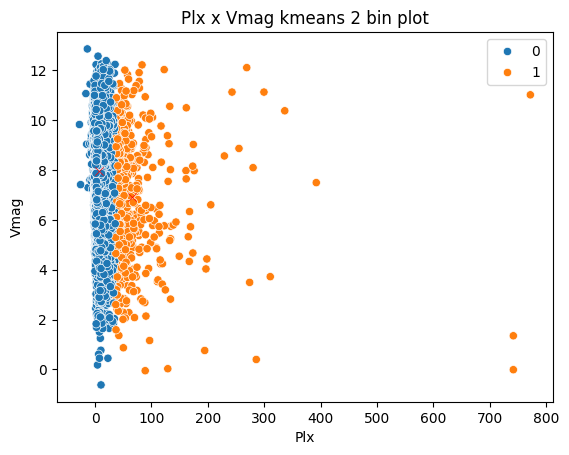

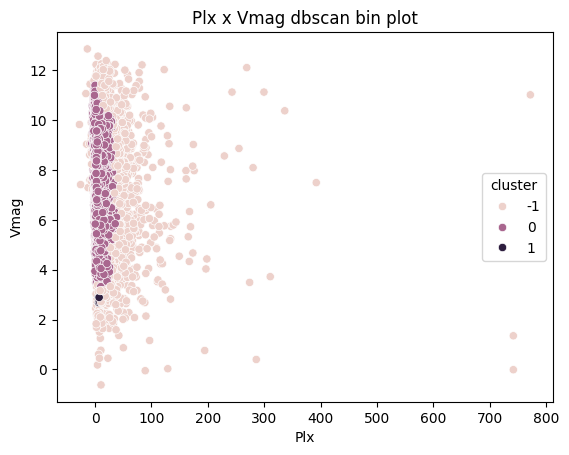

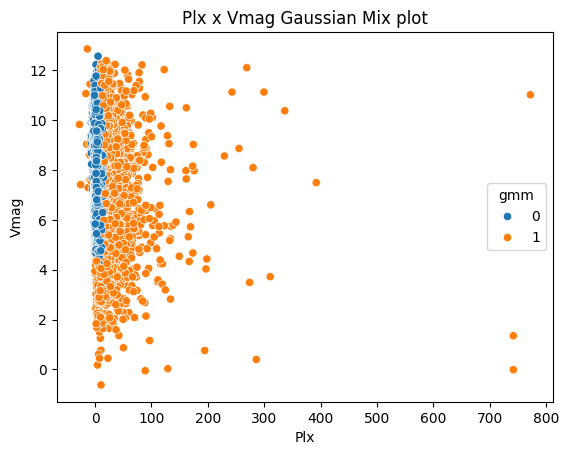

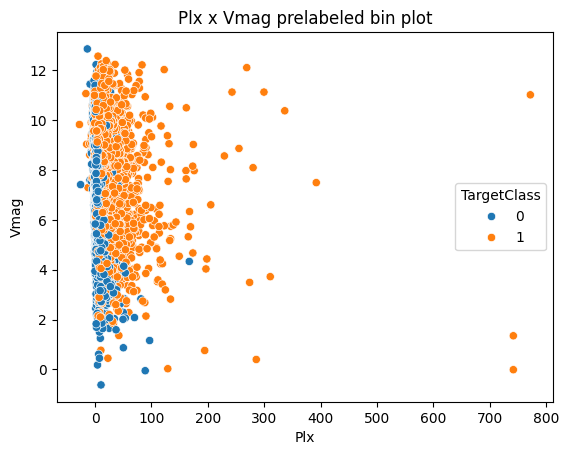

Accuracy Results:
KMeans: 0.48520934466019416
Gaussian Mix: 0.5694023058252428
DBSCAN: 0.5161306634304207


In [11]:
#figure, axis = plt.subplots(2, 2) 

#KMEANS observing

#init and max are pretty high since the dataset is large        
km2 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
#km3 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
   
km2.fit(df)
#km3.fit(df)

#use index as x value
#x = Plx.index.values  

clusters = pd.DataFrame(df)
clusters['label'] = km2.labels_

#scatterplot of kmeans data
sns.scatterplot(data=clusters, x='Plx', y='Vmag', hue='label')
sns.scatterplot(x=km2.cluster_centers_[:, 0], y=km2.cluster_centers_[:,1], color='red', marker='x')
plt.title("Plx x Vmag kmeans 2 bin plot")
plt.show()

km = sum(clusters['label'] != comp['TargetClass']) 

#DBSCAN
        
#maybe try with minmax scaler as well?

scaler2 = StandardScaler()
PlxStand = scaler2.fit_transform(df)
dbscan = DBSCAN(eps=0.2, min_samples=20)
clus = dbscan.fit_predict(PlxStand)
n_clusters = len(set(dbscan.labels_)) 

#ideally 3 at most ^

#visualize dbscan 
clusters = pd.DataFrame(df)
clusters['cluster'] = clus
sns.scatterplot(data=clusters, x='Plx', y='Vmag', hue='cluster')
plt.title("Plx x Vmag dbscan bin plot")
plt.show()

dbs = sum(abs(clusters['cluster']) == comp['TargetClass']) 

#Gaussian mix

gmm = GaussianMixture(n_components=2, max_iter=200)
gmm_cluster_labels = gmm.fit_predict(df)
clusters = pd.DataFrame(df)
clusters['gmm'] = gmm_cluster_labels
sns.scatterplot(data=clusters, x='Plx', y='Vmag', hue='gmm')
plt.title("Plx x Vmag Gaussian Mix plot")
plt.show()

gm = sum(clusters['gmm'] == comp['TargetClass']) 

#scatterplot of prelabeled data
sns.scatterplot(data=comp, x='Plx', y='Vmag', hue='TargetClass')
plt.title("Plx x Vmag prelabeled bin plot")
plt.show()

#compare results
print("Accuracy Results:")
print("KMeans:", km/len(comp['TargetClass']))
print("Gaussian Mix:", gm/len(comp['TargetClass']))
print("DBSCAN:", dbs/len(comp['TargetClass']))

#### Visual Magnitude & Color Index

*Overview*

In [12]:
#prepare data to run later
data = pd.DataFrame([BV, Vmag])

df = pd.DataFrame.transpose(data)

BINS
[39552 39552]
EDGES
[array([ 1.213 ,  5.6065, 10.    ]) array([1.13 , 4.695, 8.26 ])
 array([0.596, 4.433, 8.27 ]) ... array([0.227 , 4.7185, 9.21  ])
 array([1.467 , 5.2385, 9.01  ]) array([0.48, 4.8 , 9.12])] 3


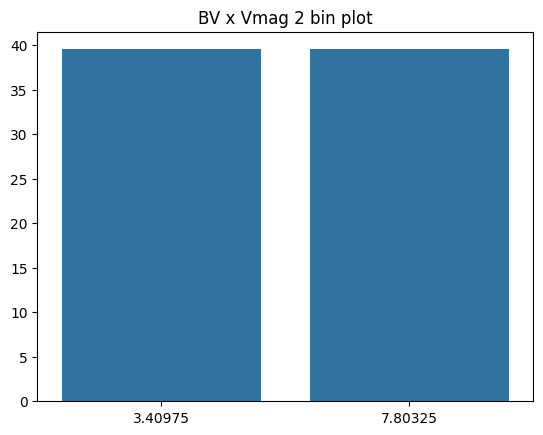

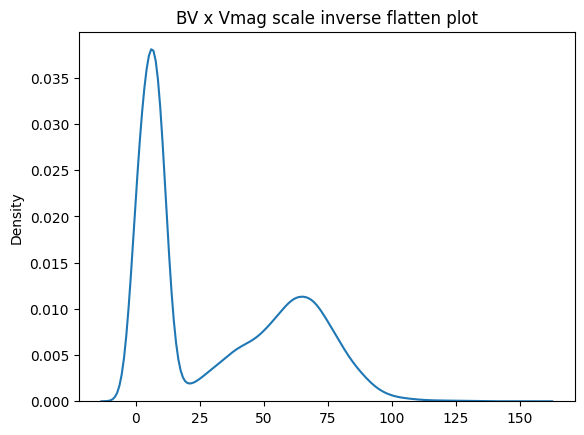

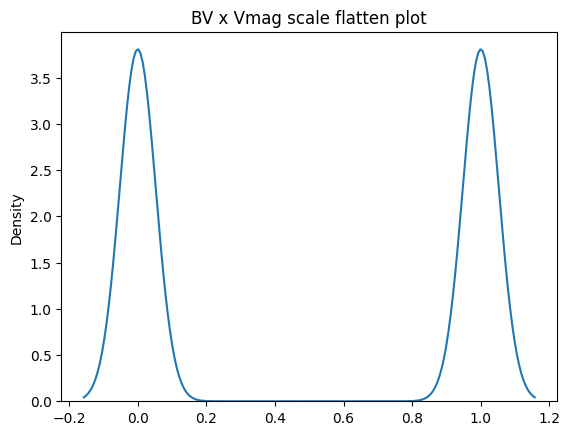

In [13]:
#Kbins

#3 bins arent needed after testing this
kb2 = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
#kb3 = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
BVbin2 = kb2.fit_transform(data)
#BVbin3 = kb3.fit_transform(data)

bins2 = np.bincount(np.ndarray.flatten(BVbin2).astype(int))
#bins3 = np.bincount(np.ndarray.flatten(BVbin3).astype(int))

print("BINS")
print(bins2)
#print(bins3)

edges2 = kb2.bin_edges_
#edges3 = kb3.bin_edges_

print("EDGES")
print(edges2, len(edges2[0]))
#print(edges3, len(edges3[0]))

coods_2 = [(edges2[0][i] + edges2[0][i+1])/2 for i in range(len(edges2[0]) - 1)]
#coods_3 = [(edges3[0][i] + edges3[0][i+1])/2 for i in range(len(edges3[0]) - 1)]

#bin plots
sns.barplot(x=coods_2, y=bins2/1000)
plt.title("BV x Vmag 2 bin plot")
plt.show()

#sns.barplot(x=coods_3, y=bins3/1000)
#plt.title("BV 3 bin plot")
#plt.show()

#minmax scaler

scaler = MinMaxScaler()
BV_sca = scaler.fit_transform(data)
BV_inv = scaler.inverse_transform(data)


sns.kdeplot(x=BV_inv.flatten())
plt.title("BV x Vmag scale inverse flatten plot")
plt.show()

sns.kdeplot(x=BV_sca.flatten())
plt.title("BV x Vmag scale flatten plot")
plt.show()


*Observing Clusters*

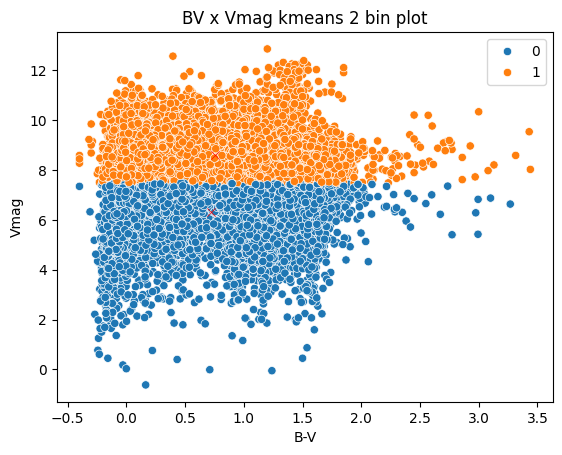

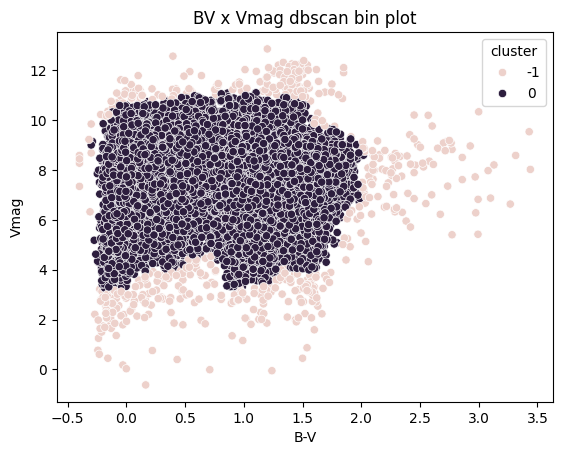

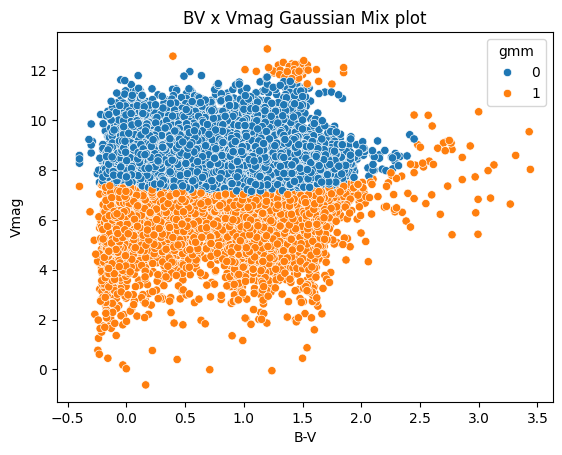

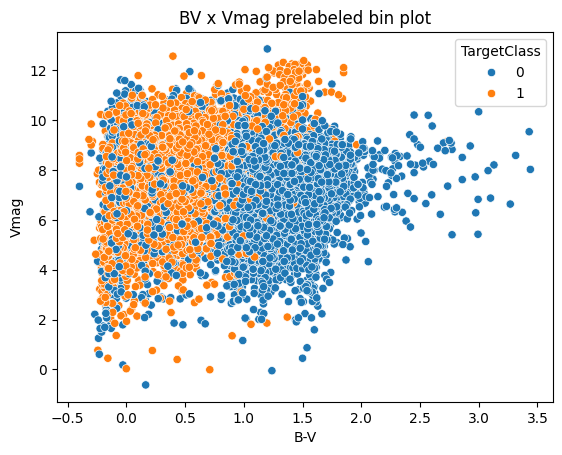

Accuracy Results:
KMeans: 0.444604571197411
Gaussian Mix: 0.5407311893203883


In [14]:
#figure, axis = plt.subplots(2, 2) 

#KMEANS observing

#init and max are pretty high since the dataset is large        
km2 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
#km3 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
   
km2.fit(df)
#km3.fit(df)

#use index as x value
#x = BV.index.values  

clusters = pd.DataFrame(df)
clusters['label'] = km2.labels_

#scatterplot of kmeans data
sns.scatterplot(data=clusters, x='B-V', y='Vmag', hue='label')
sns.scatterplot(x=km2.cluster_centers_[:, 0], y=km2.cluster_centers_[:,1], color='red', marker='x')
plt.title("BV x Vmag kmeans 2 bin plot")
plt.show()

km = sum(clusters['label'] != comp['TargetClass']) 

#DBSCAN
        
#maybe try with minmax scaler as well?

scaler2 = StandardScaler()
BVStand = scaler2.fit_transform(df)
dbscan = DBSCAN(eps=0.2, min_samples=20)
clus = dbscan.fit_predict(BVStand)
n_clusters = len(set(dbscan.labels_)) 

#ideally 3 at most ^

#visualize dbscan 
clusters = pd.DataFrame(df)
clusters['cluster'] = clus
sns.scatterplot(data=clusters, x='B-V', y='Vmag', hue='cluster')
plt.title("BV x Vmag dbscan bin plot")
plt.show()

#Gaussian mix

gmm = GaussianMixture(n_components=2, max_iter=200)
gmm_cluster_labels = gmm.fit_predict(df)
clusters = pd.DataFrame(df)
clusters['gmm'] = gmm_cluster_labels
sns.scatterplot(data=clusters, x='B-V', y='Vmag', hue='gmm')
plt.title("BV x Vmag Gaussian Mix plot")
plt.show()
gm = sum(clusters['gmm'] != comp['TargetClass']) 



#scatterplot of prelabeled data
sns.scatterplot(data=comp, x='B-V', y='Vmag', hue='TargetClass')
plt.title("BV x Vmag prelabeled bin plot")
plt.show()

#compare results
print("Accuracy Results:")
print("KMeans:", km/len(comp['TargetClass']))
print("Gaussian Mix:", gm/len(comp['TargetClass']))

#### Distance from Earth & Color Index

*Overview*

In [15]:
data = pd.DataFrame([BV, Plx])

df = pd.DataFrame.transpose(data)

BINS
[39561 39543]
EDGES
[array([ 1.213 , 16.4365, 31.66  ]) array([1.13, 2.17, 3.21])
 array([ 0.596,  6.673, 12.75 ]) ... array([0.227 , 2.0585, 3.89  ])
 array([1.467 , 1.7985, 2.13  ]) array([0.48, 2.15, 3.82])] 3


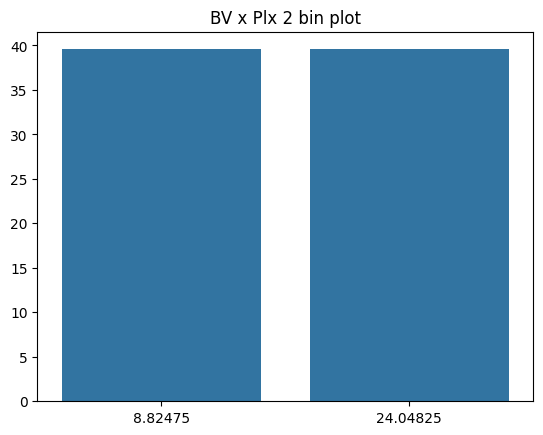

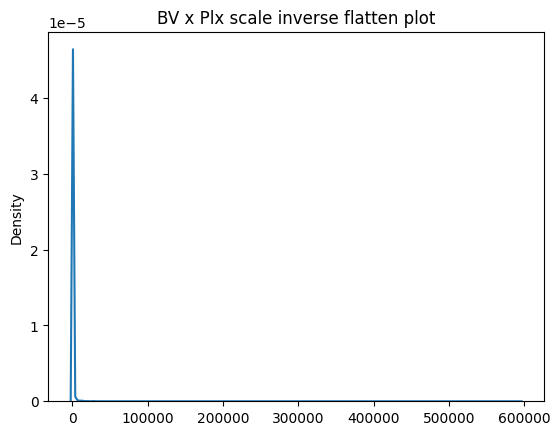

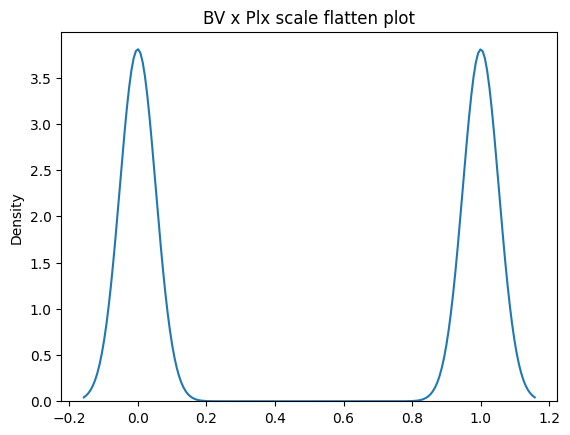

In [16]:
#Kbins

#3 bins arent needed after testing this
kb2 = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
#kb3 = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
BVbin2 = kb2.fit_transform(data)
#BVbin3 = kb3.fit_transform(data)

bins2 = np.bincount(np.ndarray.flatten(BVbin2).astype(int))
#bins3 = np.bincount(np.ndarray.flatten(BVbin3).astype(int))

print("BINS")
print(bins2)
#print(bins3)

edges2 = kb2.bin_edges_
#edges3 = kb3.bin_edges_

print("EDGES")
print(edges2, len(edges2[0]))
#print(edges3, len(edges3[0]))

coods_2 = [(edges2[0][i] + edges2[0][i+1])/2 for i in range(len(edges2[0]) - 1)]
#coods_3 = [(edges3[0][i] + edges3[0][i+1])/2 for i in range(len(edges3[0]) - 1)]

#bin plots
sns.barplot(x=coods_2, y=bins2/1000)
plt.title("BV x Plx 2 bin plot")
plt.show()

#sns.barplot(x=coods_3, y=bins3/1000)
#plt.title("BV 3 bin plot")
#plt.show()

#minmax scaler

scaler = MinMaxScaler()
BV_sca = scaler.fit_transform(data)
BV_inv = scaler.inverse_transform(data)


sns.kdeplot(x=BV_inv.flatten())
plt.title("BV x Plx scale inverse flatten plot")
plt.show()

sns.kdeplot(x=BV_sca.flatten())
plt.title("BV x Plx scale flatten plot")
plt.show()


*Observing Clusters*

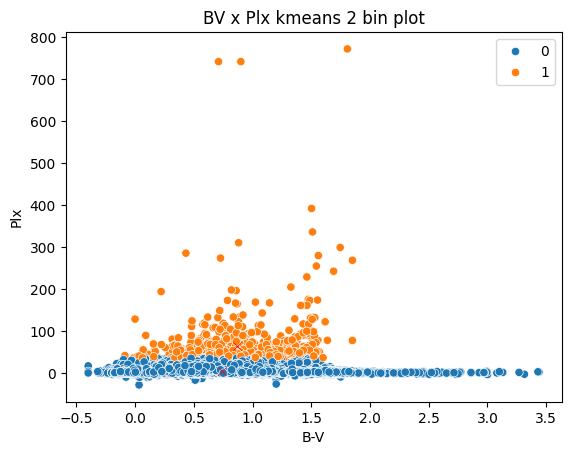

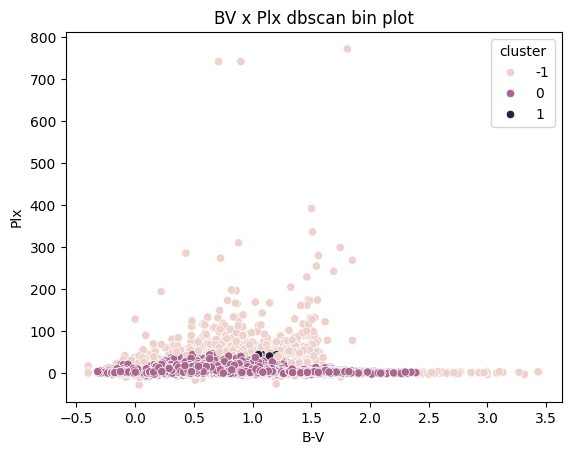

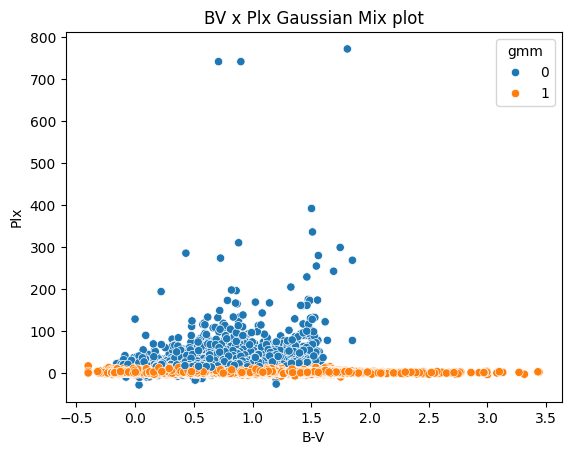

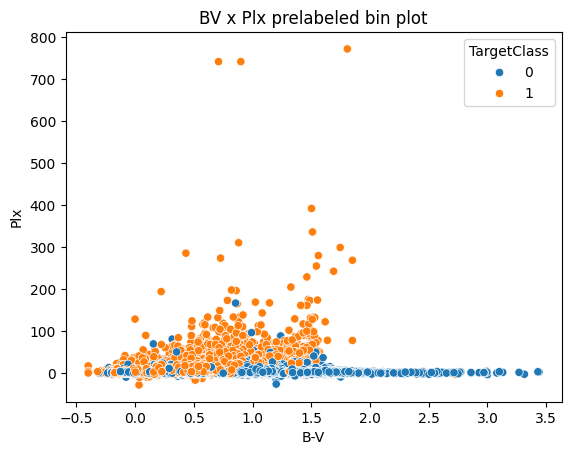

Accuracy Results:
KMeans: 0.4853104773462783
Gaussian Mix: 0.41487156148867316
DBSCAN: 0.5102396844660194


In [17]:
#figure, axis = plt.subplots(2, 2) 

#KMEANS observing

#init and max are pretty high since the dataset is large        
km2 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
#km3 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
   
km2.fit(df)
#km3.fit(df)

#use index as x value
#x = BV.index.values  

clusters = pd.DataFrame(df)
clusters['label'] = km2.labels_

#scatterplot of kmeans data
sns.scatterplot(data=clusters, x='B-V', y='Plx', hue='label')
sns.scatterplot(x=km2.cluster_centers_[:, 0], y=km2.cluster_centers_[:,1], color='red', marker='x')
plt.title("BV x Plx kmeans 2 bin plot")
plt.show()

km = sum(clusters['label'] != comp['TargetClass']) 

#DBSCAN
        
#maybe try with minmax scaler as well?

scaler2 = StandardScaler()
BVStand = scaler2.fit_transform(df)
dbscan = DBSCAN(eps=0.2, min_samples=20)
clus = dbscan.fit_predict(BVStand)
n_clusters = len(set(dbscan.labels_)) 

#ideally 3 at most ^

#visualize dbscan 
clusters = pd.DataFrame(df)
clusters['cluster'] = clus
sns.scatterplot(data=clusters, x='B-V', y='Plx', hue='cluster')
plt.title("BV x Plx dbscan bin plot")
plt.show()
dbs = sum(abs(clusters['cluster']) == comp['TargetClass']) 

#Gaussian mix

gmm = GaussianMixture(n_components=2, max_iter=200)
gmm_cluster_labels = gmm.fit_predict(df)
clusters = pd.DataFrame(df)
clusters['gmm'] = gmm_cluster_labels
sns.scatterplot(data=clusters, x='B-V', y='Plx', hue='gmm')
plt.title("BV x Plx Gaussian Mix plot")
plt.show()
gm = sum(clusters['gmm'] == comp['TargetClass']) 



#scatterplot of prelabeled data
sns.scatterplot(data=comp, x='B-V', y='Plx', hue='TargetClass')
plt.title("BV x Plx prelabeled bin plot")
plt.show()

#compare results
print("Accuracy Results:")
print("KMeans:", km/len(comp['TargetClass']))
print("Gaussian Mix:", gm/len(comp['TargetClass']))
print("DBSCAN:", dbs/len(comp['TargetClass']))

#### Actual Magnitude and Distance from Earth

*Overview*

In [18]:
data = pd.DataFrame([Amag, Plx])

df = pd.DataFrame.transpose(data)

BINS
[39552 39552]
EDGES
[array([22.502556, 27.081278, 31.66    ])
 array([ 3.21     ,  9.5012625, 15.792525 ])
 array([12.75    , 15.773776, 18.797552]) ...
 array([ 3.89    , 10.524874, 17.159748])
 array([ 2.13    ,  8.890949, 15.651898])
 array([ 3.82     , 10.4251585, 17.030317 ])] 3


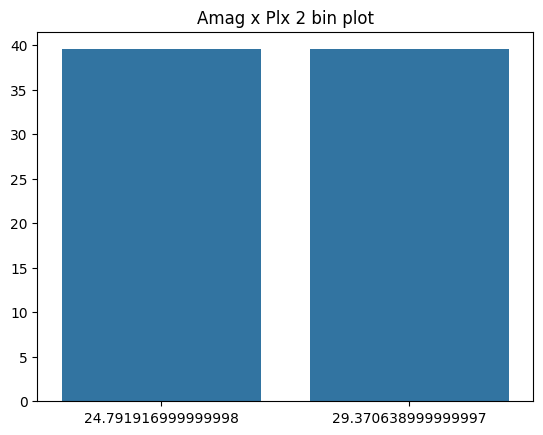

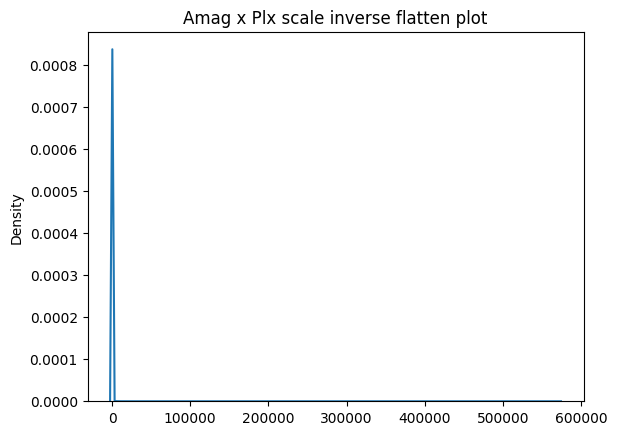

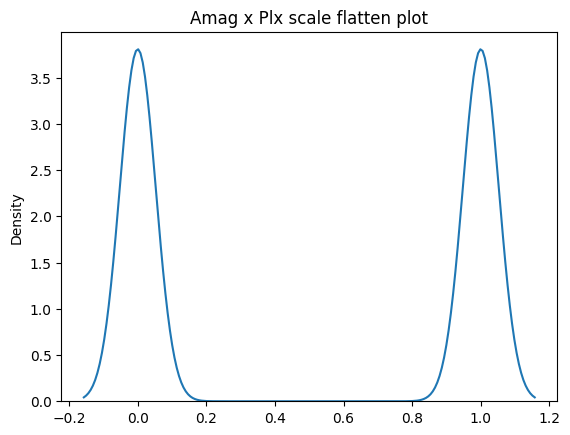

In [19]:
#Kbins

#3 bins arent needed after testing this
kb2 = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
#kb3 = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
Amagbin2 = kb2.fit_transform(data)
#Amagbin3 = kb3.fit_transform(data)

bins2 = np.bincount(np.ndarray.flatten(Amagbin2).astype(int))
#bins3 = np.bincount(np.ndarray.flatten(Amagbin3).astype(int))

print("BINS")
print(bins2)
#print(bins3)

edges2 = kb2.bin_edges_
#edges3 = kb3.bin_edges_

print("EDGES")
print(edges2, len(edges2[0]))
#print(edges3, len(edges3[0]))

coods_2 = [(edges2[0][i] + edges2[0][i+1])/2 for i in range(len(edges2[0]) - 1)]
#coods_3 = [(edges3[0][i] + edges3[0][i+1])/2 for i in range(len(edges3[0]) - 1)]

#bin plots
sns.barplot(x=coods_2, y=bins2/1000)
plt.title("Amag x Plx 2 bin plot")
plt.show()

#sns.barplot(x=coods_3, y=bins3/1000)
#plt.title("Amag 3 bin plot")
#plt.show()

#minmax scaler

scaler = MinMaxScaler()
Amag_sca = scaler.fit_transform(data)
Amag_inv = scaler.inverse_transform(data)


sns.kdeplot(x=Amag_inv.flatten())
plt.title("Amag x Plx scale inverse flatten plot")
plt.show()

sns.kdeplot(x=Amag_sca.flatten())
plt.title("Amag x Plx scale flatten plot")
plt.show()

*Observing Clusters*

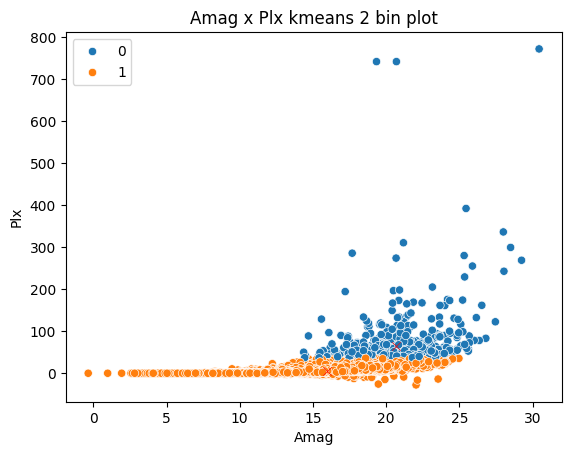

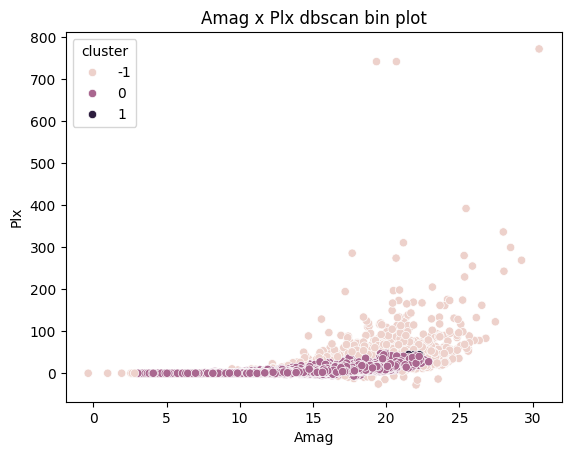

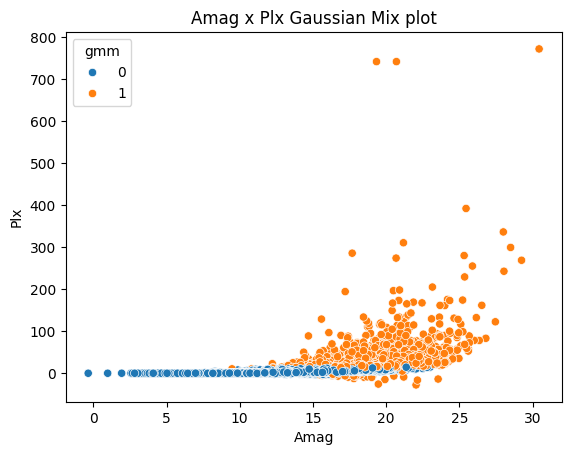

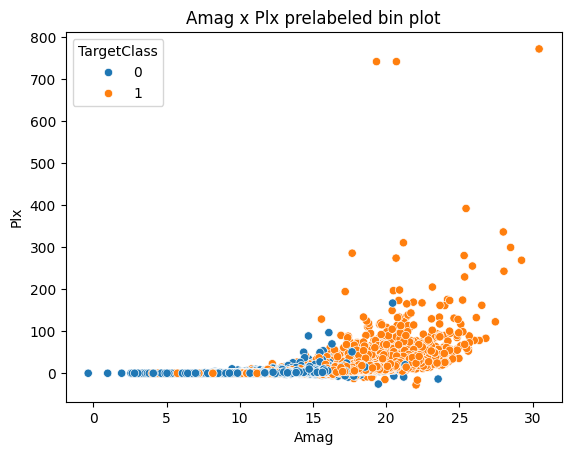

Accuracy Results:
KMeans: 0.5147906553398058
Gaussian Mix: 0.57959142394822
DBSCAN: 0.5112510113268608


In [20]:
#figure, axis = plt.subplots(2, 2) 

#KMEANS observing

#init and max are pretty high since the dataset is large        
km2 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
#km3 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
   
km2.fit(df)
#km3.fit(df)

#use index as x value
#x = Amag.index.values  

clusters = pd.DataFrame(df)
clusters['label'] = km2.labels_

#scatterplot of kmeans data
sns.scatterplot(data=clusters, x='Amag', y='Plx', hue='label')
sns.scatterplot(x=km2.cluster_centers_[:, 0], y=km2.cluster_centers_[:,1], color='red', marker='x')
plt.title("Amag x Plx kmeans 2 bin plot")
plt.show()

km = sum(clusters['label'] != comp['TargetClass']) 

#DBSCAN
        
#maybe try with minmax scaler as well?

scaler2 = StandardScaler()
AmagStand = scaler2.fit_transform(df)
dbscan = DBSCAN(eps=0.2, min_samples=20)
clus = dbscan.fit_predict(AmagStand)
n_clusters = len(set(dbscan.labels_)) 

#ideally 3 at most ^

#visualize dbscan 
clusters = pd.DataFrame(df)
clusters['cluster'] = clus
sns.scatterplot(data=clusters, x='Amag', y='Plx', hue='cluster')
plt.title("Amag x Plx dbscan bin plot")
plt.show()
dbs = sum(abs(clusters['cluster']) == comp['TargetClass']) 

#Gaussian mix

gmm = GaussianMixture(n_components=2, max_iter=200)
gmm_cluster_labels = gmm.fit_predict(df)
clusters = pd.DataFrame(df)
clusters['gmm'] = gmm_cluster_labels
sns.scatterplot(data=clusters, x='Amag', y='Plx', hue='gmm')
plt.title("Amag x Plx Gaussian Mix plot")
plt.show()
gm = sum(clusters['gmm'] == comp['TargetClass']) 



#scatterplot of prelabeled data
sns.scatterplot(data=comp, x='Amag', y='Plx', hue='TargetClass')
plt.title("Amag x Plx prelabeled bin plot")
plt.show()

#compare results
print("Accuracy Results:")
print("KMeans:", km/len(comp['TargetClass']))
print("Gaussian Mix:", gm/len(comp['TargetClass']))
print("DBSCAN:", dbs/len(comp['TargetClass']))

#### Actual Magnitude vs Color Index

*Overview*

In [21]:
data = pd.DataFrame([Amag, BV])

df = pd.DataFrame.transpose(data)

BINS
[39552 39552]
EDGES
[array([ 1.213   , 11.857778, 22.502556])
 array([ 1.13     ,  8.4612625, 15.792525 ])
 array([ 0.596   ,  9.696776, 18.797552]) ...
 array([ 0.227   ,  8.693374, 17.159748])
 array([ 1.467   ,  8.559449, 15.651898])
 array([ 0.48     ,  8.7551585, 17.030317 ])] 3


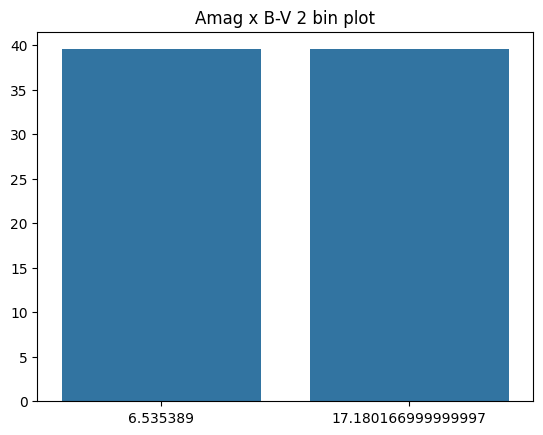

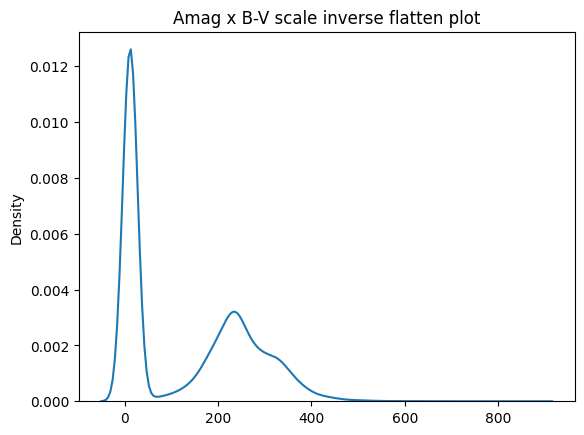

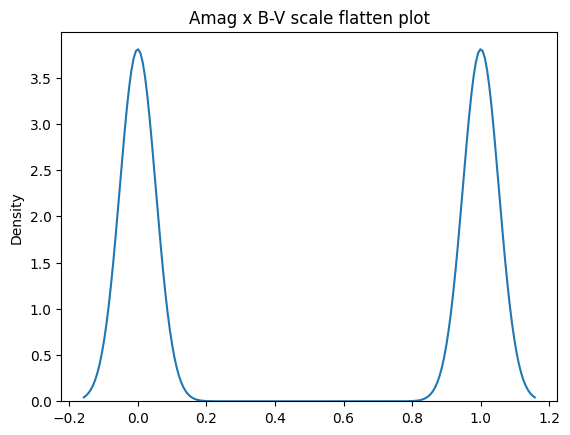

In [22]:
#Kbins

#3 bins arent needed after testing this
kb2 = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
#kb3 = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
Amagbin2 = kb2.fit_transform(data)
#Amagbin3 = kb3.fit_transform(data)

bins2 = np.bincount(np.ndarray.flatten(Amagbin2).astype(int))
#bins3 = np.bincount(np.ndarray.flatten(Amagbin3).astype(int))

print("BINS")
print(bins2)
#print(bins3)

edges2 = kb2.bin_edges_
#edges3 = kb3.bin_edges_

print("EDGES")
print(edges2, len(edges2[0]))
#print(edges3, len(edges3[0]))

coods_2 = [(edges2[0][i] + edges2[0][i+1])/2 for i in range(len(edges2[0]) - 1)]
#coods_3 = [(edges3[0][i] + edges3[0][i+1])/2 for i in range(len(edges3[0]) - 1)]

#bin plots
sns.barplot(x=coods_2, y=bins2/1000)
plt.title("Amag x B-V 2 bin plot")
plt.show()

#sns.barplot(x=coods_3, y=bins3/1000)
#plt.title("Amag 3 bin plot")
#plt.show()

#minmax scaler

scaler = MinMaxScaler()
Amag_sca = scaler.fit_transform(data)
Amag_inv = scaler.inverse_transform(data)


sns.kdeplot(x=Amag_inv.flatten())
plt.title("Amag x B-V scale inverse flatten plot")
plt.show()

sns.kdeplot(x=Amag_sca.flatten())
plt.title("Amag x B-V scale flatten plot")
plt.show()

*Observing Clusters*

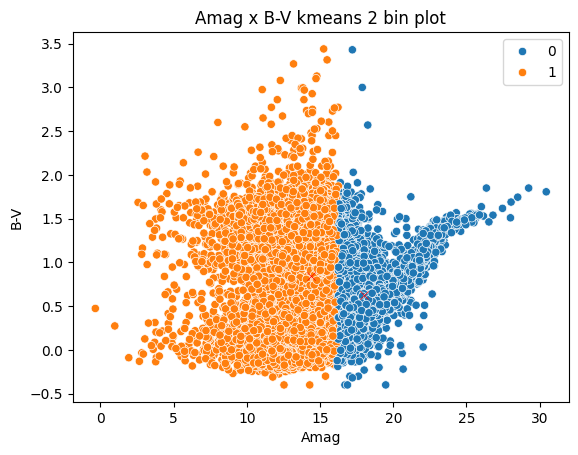

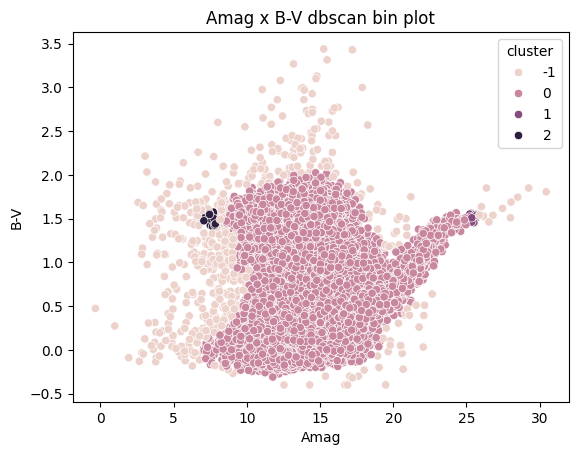

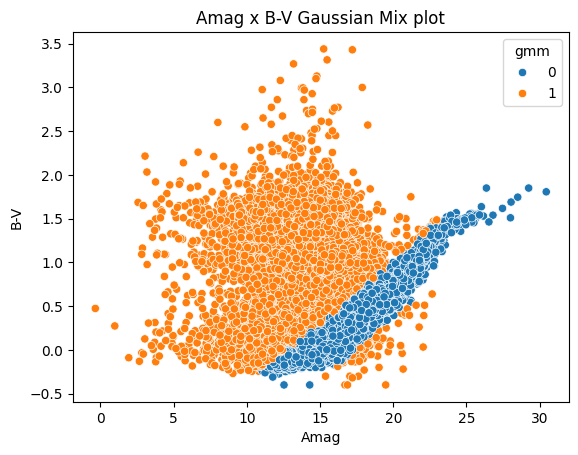

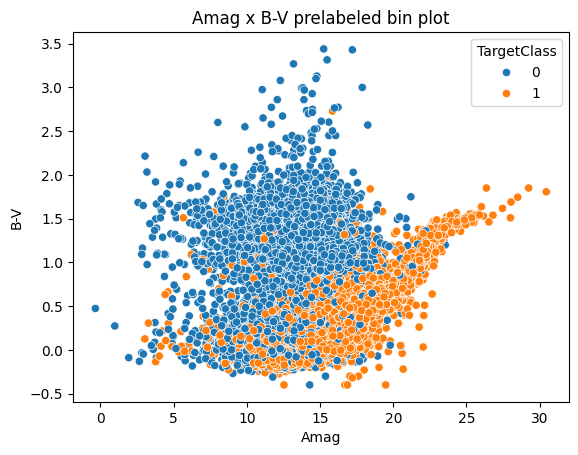

Accuracy Results:
KMeans: 0.7449433656957929
Gaussian Mix: 0.14001820388349515
DBSCAN: 0.4911003236245955


In [23]:
#figure, axis = plt.subplots(2, 2) 

#KMEANS observing

#init and max are pretty high since the dataset is large        
km2 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
#km3 = KMeans(n_clusters=2, init='random', n_init=300, max_iter=1000, random_state=seed)
   
km2.fit(df)
#km3.fit(df)

#use index as x value
#x = Amag.index.values  

clusters = pd.DataFrame(df)
clusters['label'] = km2.labels_

#scatterplot of kmeans data
sns.scatterplot(data=clusters, x='Amag', y='B-V', hue='label')
sns.scatterplot(x=km2.cluster_centers_[:, 0], y=km2.cluster_centers_[:,1], color='red', marker='x')
plt.title("Amag x B-V kmeans 2 bin plot")
plt.show()

km = sum(clusters['label'] != comp['TargetClass']) 

#DBSCAN
        
#maybe try with minmax scaler as well?

scaler2 = StandardScaler()
AmagStand = scaler2.fit_transform(df)
dbscan = DBSCAN(eps=0.2, min_samples=20)
clus = dbscan.fit_predict(AmagStand)
n_clusters = len(set(dbscan.labels_)) 

#ideally 3 at most ^

#visualize dbscan 
clusters = pd.DataFrame(df)
clusters['cluster'] = clus
sns.scatterplot(data=clusters, x='Amag', y='B-V', hue='cluster')
plt.title("Amag x B-V dbscan bin plot")
plt.show()
dbs = sum(abs(clusters['cluster']) == comp['TargetClass']) 

#Gaussian mix

gmm = GaussianMixture(n_components=2, max_iter=200)
gmm_cluster_labels = gmm.fit_predict(df)
clusters = pd.DataFrame(df)
clusters['gmm'] = gmm_cluster_labels
sns.scatterplot(data=clusters, x='Amag', y='B-V', hue='gmm')
plt.title("Amag x B-V Gaussian Mix plot")
plt.show()
gm = sum(clusters['gmm'] == comp['TargetClass']) 



#scatterplot of prelabeled data
sns.scatterplot(data=comp, x='Amag', y='B-V', hue='TargetClass')
plt.title("Amag x B-V prelabeled bin plot")
plt.show()

#compare results
print("Accuracy Results:")
print("KMeans:", km/len(comp['TargetClass']))
print("Gaussian Mix:", gm/len(comp['TargetClass']))
print("DBSCAN:", dbs/len(comp['TargetClass']))

### Visualizing Correlation between Numerical Variables vs Spectral Type and Giant/Dwarf Classification

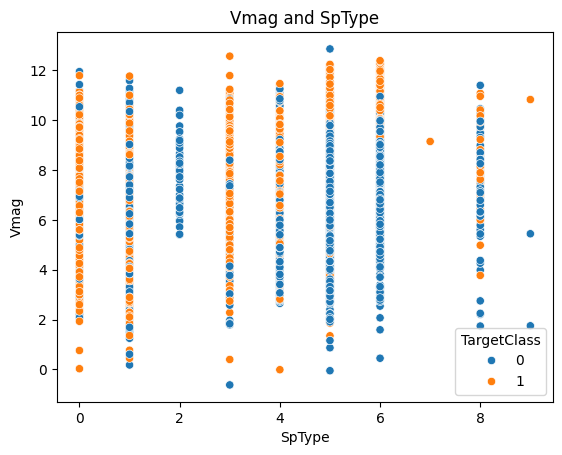

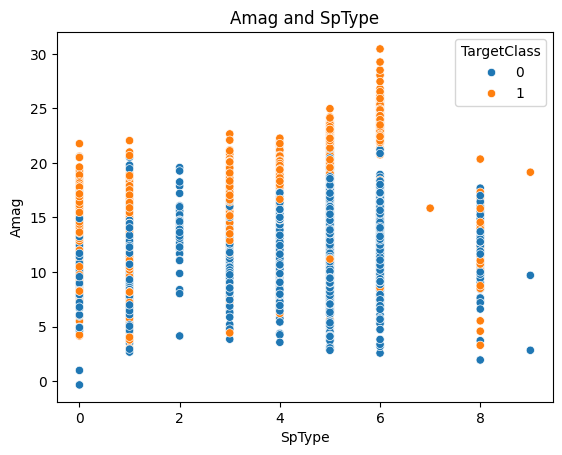

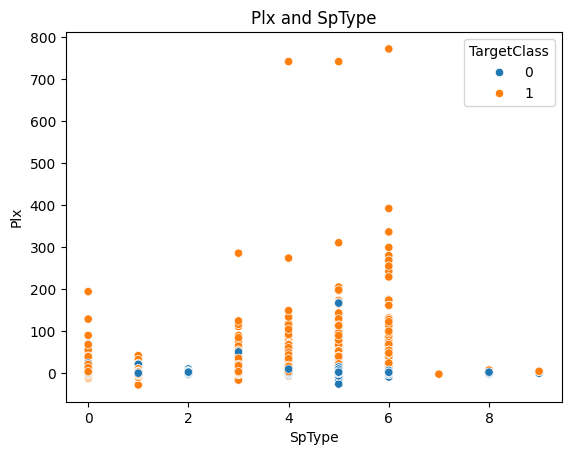

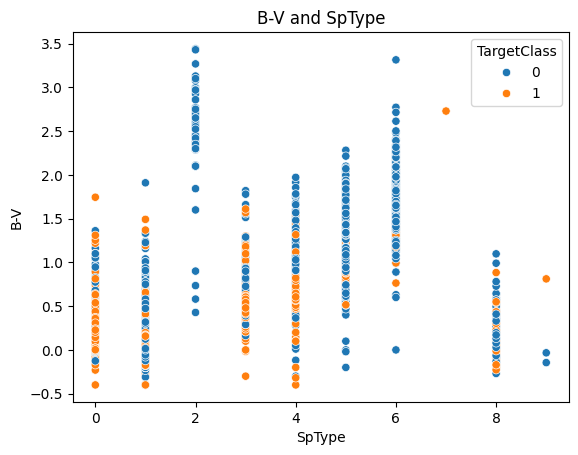

In [24]:
#SCATTERPLOTS

sns.scatterplot(data=star39552, x='SpType', y='Vmag', hue='TargetClass')
plt.title("Vmag and SpType")
plt.show()

sns.scatterplot(data=star39552, x='SpType', y='Amag', hue='TargetClass')
plt.title("Amag and SpType")
plt.show()

sns.scatterplot(data=star39552, x='SpType', y='Plx', hue='TargetClass')
plt.title("Plx and SpType")
plt.show()

sns.scatterplot(data=star39552, x='SpType', y='B-V', hue='TargetClass')
plt.title("B-V and SpType")
plt.show()


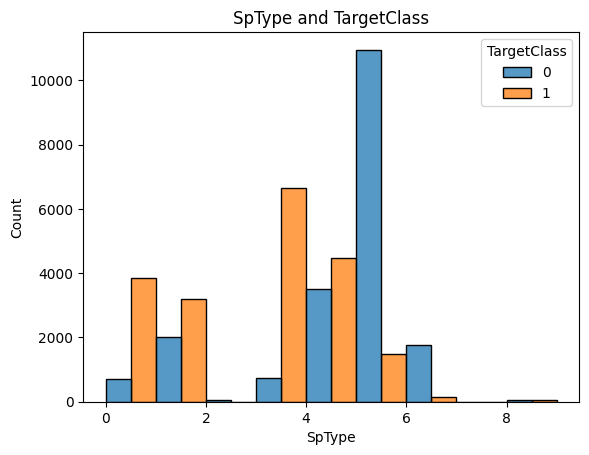

In [25]:
#BARPLOT

fig, ax = plt.subplots()
sns.histplot(
    data=star39552, x='SpType', hue='TargetClass', multiple='dodge',
    bins=encoder.transform(cat), ax=ax
)
plt.title("SpType and TargetClass")
plt.show()

## Analysis of pre-processing results


### Numerical Analysis

#### Correlation
- Plx and Amag have the highest correlation 
- Amag and Vmag have a decent correlation
- Removing outliers greatly increases correlation between Amag and Plx
- Removing outliers shows even lower correlation between B-V and Vmag
- Removing outliers increases correlation between Plx and Vmag, B-V and Plx

#### Labeling

1. Vmag vs Amag
 - clear division btwn 2 parts kbin analysis
 - k-means shows highest accuracy (73%)
 - DBSCAN very inaccurate classification
2. Plx vs Vmag
 - clear division btwn 2 parts kbin analysis
 - All classification types around 50%
 - highest is gaussian mix at 56%
 - kmeans and dbscan around the same, DBSCAN a bit higher
 - normalizing increases Gaussian Mix to 63%, and Kmeans to 60%
 - DBScan still stays at 50 ish
3. Vmag vs B-V
 - Gaussian Mix has highest accuracy at 86%
 - All binarization methods seem inaccurate
 - Highest is Gaussian Mix at 45%
 - normalizing keeps accuracy the same
4. Plx vs B-V
 - All analysis give around 50%
 - highest is Gaussian Mix at 58%
 - normalizing incrases gaussian mix to 66%
 - it also lowers kmeans to 39%
5. Amag vs Plx
- Around 50% on all, gaussian mix highest at 57%
- Removing outliers increases all accuracy
- Kmeans and Gaussian mix a little over 60% accuracy
- Gaussian mix at 63%
- Dbscan only recognizes 2 clusters instead of 3 after removing outliers
6. Amag vs B-V
- Gaussian mix very accurate 86% removing outliers doesnt change
- Kmeans stays at 74% before and after removing outliers
- Dbscan does not separate groups very well even after removing outliers

### Categorical Analysis

- lower(<9) Vmag around SpType 5+ tends to be type 0
- lower(<15) Amag from SpType 2-6 tends to be type 0
- most SpType 2 tends to be type 0
- higher(>15) Amag from SpType 3-6 tends to be type 1
- Very high(>200) Plx is always type 1
- Higher Plx = Higher chance of type 1
- Higher(>2.0) B-V tends to be type 0
- Type 1 is more common across SpType 0-4 (except 2)
- Type 0 is more common Across SpType 5-8